<a href="https://colab.research.google.com/github/koidula/SIAST-Tech-NeuralDriver/blob/main/Binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Импорт модулей.

In [77]:
from google.colab import drive
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential, Model
import numpy as np
import pandas as pd
import os
import tensorflow.keras.backend as K
from sklearn.metrics import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

In [78]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Перенесение датасета в рабочую область.


Для этого, в основном, будут использоваться инструменты pandas dataframe. А также библиотек sklearn и seaborn.

===========================================================

Dataset Analysis
Main tool is pandas dataframe, sklearn and seaborn as instrument for nice heatmap.

In [79]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Загрузка датасета по частям с дальнейшей конкатенацией. 
df1=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")#,nrows = 50000
df2=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Monday-WorkingHours.pcap_ISCX.csv")
df5=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Tuesday-WorkingHours.pcap_ISCX.csv")
df8=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Wednesday-workingHours.pcap_ISCX.csv")

#Вывод уникальных признаков типов аттак или benign для каждого датасета. Ожидается DDoS, DoS Types и т.д.
print (df1[' Label'].unique())
print (df2[' Label'].unique())
print (df3[' Label'].unique())
print (df4[' Label'].unique())
print (df5[' Label'].unique())
print (df6[' Label'].unique())
print (df7[' Label'].unique())
print (df8[' Label'].unique(), "\n")

#Конкатенация и общая информация о наборе данных
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df= pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8
data = df.copy() #Датафрейм копируем в дату для дальнейших операций
data.info()



['BENIGN' 'DDoS']
['BENIGN' 'PortScan']
['BENIGN' 'Bot']
['BENIGN']
['BENIGN' 'Infiltration']
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
['BENIGN' 'FTP-Patator' 'SSH-Patator']
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Len

# 3. Необязательный шаг.



Тепловая карта для сырого датасета. Благодаря ней можно понять основные недостатки сырого датасета и с ними работать в дальнейшем препроцессинге.

In [80]:
#fig= plt.figure(figsize=(70,70))
#sns.heatmap(data.corr(), annot=True)

# 4. Необходимо отбросить пустые значения из изначального датасета.


Подтягиваем из датасета колонки с NaN и создаем из них массив deleteCol. Получившийся массив "вычитаем" из дата.

In [81]:
deleteCol = []
for column in data.columns:
    if data[column].isnull().values.any():
        deleteCol.append(column)
for column in deleteCol:
    data.drop([column],axis=1,inplace=True)


Аналогично поступаем с элементами numpy.object

In [82]:
deleteCol = []
for column in data.columns:
    if column == ' Label':
        continue
    elif data[column].dtype==np.object:
        deleteCol.append(column)
for column in deleteCol:
    data.drop(column,axis=1,inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


# 5. Выявим уникальные значения метрики Flow Duration

In [83]:
data[' Flow Duration'].unique()

array([       3,      109,       52, ..., 11509095, 11512230,  1048635])

# 6. Привидем каждый столбец к единому числовому типу на основе максимального значения в выбранном столбце.

In [84]:
#int8   от отрицательного -128 до положительного 127
#int16  от отрицательного -32768 до положительных 32767
#int32  от отрицательного 2 147 483 648 до положительного 2 147 483 647

for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
#Проверим типы данных
data.info()
#Проверим количество маркированных пакетов
print(data[" Label"].value_counts(), "\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 78 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int32  
 1    Flow Duration                int32  
 2    Total Fwd Packets            int32  
 3    Total Backward Packets       int32  
 4   Total Length of Fwd Packets   int32  
 5    Total Length of Bwd Packets  int32  
 6    Fwd Packet Length Max        int16  
 7    Fwd Packet Length Min        int16  
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         int16  
 11   Bwd Packet Length Min        int16  
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14   Flow Packets/s               float32
 15   Flow IAT Mean                float32
 16   Flow IAT Std                 float32
 17   Flow IAT Max                 int32  
 18   Flow IAT Min          

# 7. Очистка датасета от пустых и бесконечных значений.

In [85]:
# Проверим количество потерянных значений в датасете
print(f"Missing values: {data.isnull().sum().sum()}", "\n")
#Проверим датасет на бесконечные значения. Заменим их на NaN, так как их потом просто удалить.
data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {data.isnull().sum().sum()}", "\n")

Missing values: 0 

Missing values: 2867 



# 8. Ключевая проверка датасета на кол-во маркированных пакетов для последующего семплирования.

In [86]:
print(data[' Label'].value_counts(), "\n")

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64 



# 9. Семплирование (Основная настройка во 2 статье)


Процедура предназначена для проведения качественного обучения НС в заданных соотношениях. То есть, мы исключим ситуацию, где из 100 элементов 95% - одного типа. 

По дефолту оставил 0.5, т.е. из всех оставшихся строк, маркированных как, допустим, "Heartbleed", будут выбраны 50%. В дальнейшем удобно корректтировать их семплирование, благодаря громоздкому реплицированному коду.

In [87]:
#Bot = data[data[' Label'] == 'Bot'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Bot']
#data = pd.concat([attack, Bot])
#print(data[' Label'].value_counts(), "\n")

#Infiltration = data[data[' Label'] == 'Infiltration'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Infiltration']
#data = pd.concat([attack, Infiltration])
#print(data[' Label'].value_counts(), "\n")

#BF = data[data[' Label'] == 'Web Attack � Brute Force'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Brute Force']
#data = pd.concat([attack, BF])
#print(data[' Label'].value_counts(), "\n")

#XSS = data[data[' Label'] == 'Web Attack � XSS'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � XSS']
#data = pd.concat([attack, XSS])
#print(data[' Label'].value_counts(), "\n")

#SQLI = data[data[' Label'] == 'Web Attack � Sql Injection'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Sql Injection']
#data = pd.concat([attack, SQLI])
#print(data[' Label'].value_counts(), "\n")

#FTPP = data[data[' Label'] == 'FTP-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'FTP-Patator']
#data = pd.concat([attack, FTPP])
#print(data[' Label'].value_counts(), "\n")

#SSHP = data[data[' Label'] == 'SSH-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'SSH-Patator']
#data = pd.concat([attack, SSHP])
#print(data[' Label'].value_counts(), "\n")

#DOSs = data[data[' Label'] == 'DoS slowloris'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS slowloris']
#data = pd.concat([attack, DOSs])
#print(data[' Label'].value_counts(), "\n")

#DOShttp = data[data[' Label'] == 'DoS Slowhttptest'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS Slowhttptest']
#data = pd.concat([attack, DOShttp])
#print(data[' Label'].value_counts(), "\n")



#GY = data[data[' Label'] == 'DoS GoldenEye'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS GoldenEye']
#data = pd.concat([attack, GY])
#print(data[' Label'].value_counts(), "\n")

#HB = data[data[' Label'] == 'Heartbleed'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Heartbleed']
#data = pd.concat([attack, HB])

In [88]:
benign = data[data[' Label'] == 'BENIGN'].sample(frac=0.0625).reset_index(drop=True)
attack = data[data[' Label'] != 'BENIGN']
data = pd.concat([attack, benign])
#print(data[' Label'].value_counts(), "\n")

ddos = data[data[' Label'] == 'DDoS'].sample(frac=0.08).reset_index(drop=True)
attack = data[data[' Label'] != 'DDoS']
data = pd.concat([attack, ddos])
#print(data[' Label'].value_counts(), "\n")

PortScan = data[data[' Label'] == 'PortScan'].sample(frac=0.06).reset_index(drop=True)
attack = data[data[' Label'] != 'PortScan']
data = pd.concat([attack, PortScan])
#print(data[' Label'].value_counts(), "\n")

Hulk = data[data[' Label'] == 'DoS Hulk'].sample(frac=0.04).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS Hulk']
data = pd.concat([attack, Hulk])
#print(data[' Label'].value_counts(), "\n")

#посчитаем еще раз количества маркированных итемов. По ней можно судить о корректности семплирования.
print(data[' Label'].value_counts(), "\n")


BENIGN                        142069
DoS GoldenEye                  10293
DDoS                           10242
PortScan                        9536
DoS Hulk                        9243
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name:  Label, dtype: int64 



# 10. После семплирования запишем в y - весь датасет, а без лейбла в Х. Для дальнейшего применения в выборе признаков

In [89]:
y = data[' Label']
X = data.drop([' Label'], axis=1)

# 11. Обязательная проверка полученного датасета на наличие NaN и бесконечностей. 

Ожидается: True False 

In [90]:
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))

True
False


# 12. Замена NaN на нули. .fillna предоставляет возможность поменять NaN на значение или на результат функции.

Запускать только при boolean = True np.isnan(x)

In [91]:
print(np.where(np.isnan(X)))
X = pd.DataFrame(X).fillna(0)
print(np.where(np.isnan(X)))
X.info()

(array([    37,    129,    585,    680,    693,    705,    737,    812,
         1003,   1221,   6684,  11200,  11450,  40092,  42965,  45200,
        47663,  51458,  51955,  53021,  53529,  59578,  59999,  62414,
        63074,  65193,  67679,  68265,  68951,  71723,  75093,  76338,
        77695,  80319,  81601,  81806,  81901,  83711,  84007,  84911,
        85530,  85580,  87451,  87627,  91602,  92074,  92220,  92658,
        95360,  96962,  97170,  97268,  97465,  97607, 100915, 101973,
       102183, 106320, 107491, 108682, 109064, 109115, 111799, 112802,
       114127, 114314, 115651, 116462, 117788, 121852, 122039, 124802,
       125323, 126766, 127007, 128831, 130869, 131803, 133342, 133570,
       134831, 134864, 137746, 138107, 138417, 138822, 139869, 140623,
       142914, 144193, 144855, 146074, 146475, 147174, 150150, 150228,
       150426, 154425, 154488, 154607, 154698, 155158, 157797, 159993,
       160292, 162237, 162564, 163045, 164678, 166494, 167880, 168598,
     

# 13. Выбор весомых признаков



Техника, позволяющая выбрать те признаки, которые влияют больше всего.

1. Снижает переобучение: меньшее количество избыточных данных означает меньшую вероятность принятия решений на основе избыточных данных / шуме.
2. Повышает точность. Чем меньше вводящих в заблуждение данных, тем выше точность моделирования.
3. Сокращает время обучения: меньше данных означает, что алгоритмы обучаются быстрее.

Используемая методика - SelectKBest
Метод SelectKBest оценивает признаки с помощью функции (в данном случае f_classif для классификации), а затем «удаляет все, кроме k функций с наивысшей оценкой».

In [92]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                      Specs         Score
13    Bwd Packet Length Std  14051.684484
12   Bwd Packet Length Mean  13219.043366
53     Avg Bwd Segment Size  13219.043366
10    Bwd Packet Length Max  12857.680847
40        Packet Length Std  11885.814028
38        Max Packet Length  10564.913859
41   Packet Length Variance   9507.581657
39       Packet Length Mean   9007.618236
51      Average Packet Size   8940.276169
21              Fwd IAT Std   8425.384222
72               Active Min   8090.222107
69              Active Mean   7874.065811
17             Flow IAT Max   7081.570267
22              Fwd IAT Max   7043.687667
75                 Idle Max   6999.479634
73                Idle Mean   6420.555522
76                 Idle Min   5936.156630
68     min_seg_size_forward   5196.690528
71               Active Max   5045.301146
16             Flow IAT Std   4923.443201
25             Bwd IAT Mean   4357.606252
45           PSH Flag Count   3945.862468
19            Fwd IAT Total   3570

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [30 32 55 56 57 58 59 60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [93]:
feature = pd.DataFrame()
n = len(featureScores['Specs'])
for i in featureScores.nlargest(n//2,'Score')['Specs']:
        feature[i] = data[i]
feature[' Label'] = data[' Label']

In [94]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210706 entries, 24072 to 9242
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0    Bwd Packet Length Std       210706 non-null  float64
 1    Bwd Packet Length Mean      210706 non-null  float64
 2    Avg Bwd Segment Size        210706 non-null  float64
 3   Bwd Packet Length Max        210706 non-null  int16  
 4    Packet Length Std           210706 non-null  float64
 5    Max Packet Length           210706 non-null  int16  
 6    Packet Length Variance      210706 non-null  float64
 7    Packet Length Mean          210706 non-null  float64
 8    Average Packet Size         210706 non-null  float64
 9    Fwd IAT Std                 210706 non-null  float64
 10   Active Min                  210706 non-null  int32  
 11  Active Mean                  210706 non-null  float64
 12   Flow IAT Max                210706 non-null  int32  
 1

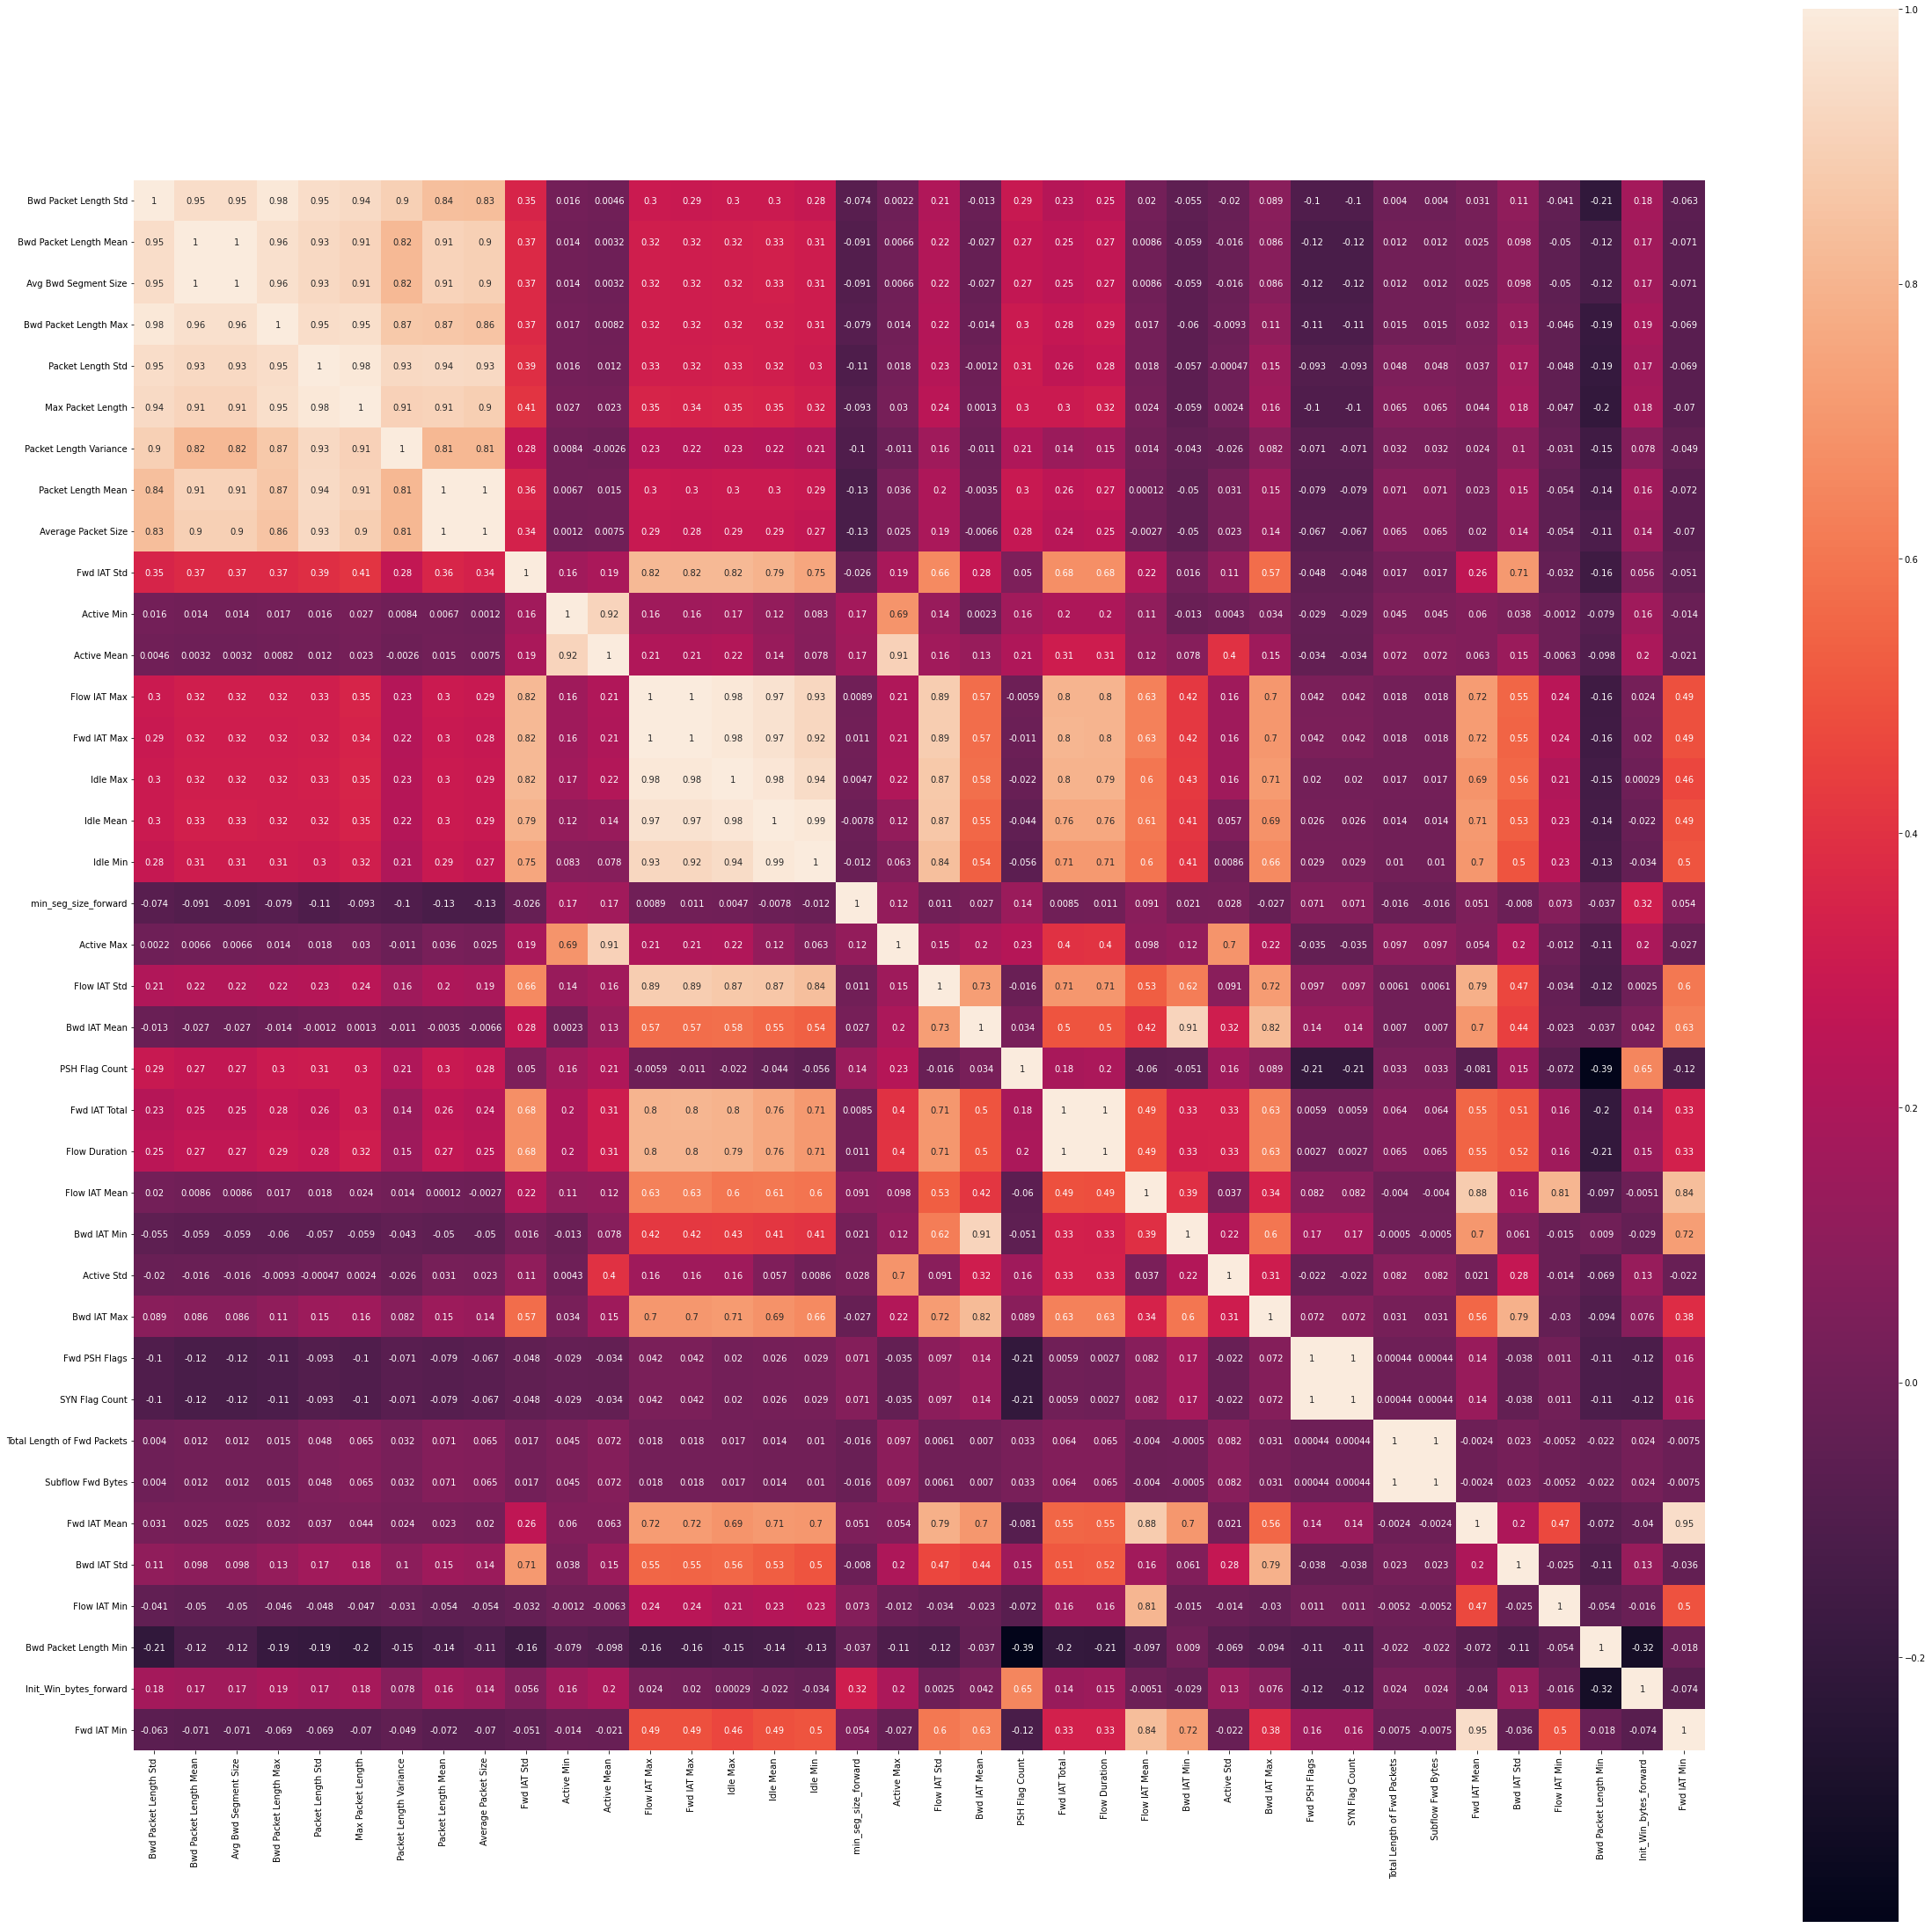

In [95]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

Корреляция, статистический метод, который определяет, как одна переменная перемещается / изменяется по отношению к другой переменной. Когда у нас есть сильно коррелированные функции в наборе данных, это увеличивает дисперсию и ненадежность. Коррелеяция замечена с признаками:

* Total Length of Bwd Packets
* Subflow Bwd Bytes
* Fwd Header Length
* Fwd Header Length.1
* Bwd Header Length
* Total Fwd Packets
* Subflow Fwd Packets
* Bwd Packets Length Mean
* Avg Bwd Segment Size
* Packet Length Std
* Bwd Packet Length Max
* Bwd Packet Length Std
* Packet Length Mean
* Flow IAT Max
* Fwd IAT Max
* Fwd IAT Total
* Idle Max
* Flow Duration
* Idle Mean
* Idle Min


                

# 14. Исключение признаков для повышения качества датасета.

См. Тепловую карту

In [96]:
#feature.drop(['Total Length of Bwd Packets'],axis=1,inplace=True)

In [97]:
#feature.drop([' Subflow Bwd Bytes'],axis=1,inplace=True)

In [98]:
#feature.drop([' Total Fwd Packets'],axis=1,inplace=True)

In [99]:
#feature.drop(['Subflow Fwd Packets'],axis=1,inplace=True)

In [100]:
feature.drop([' Bwd Packet Length Mean'],axis=1,inplace=True)

In [101]:
feature.drop([' Avg Bwd Segment Size'],axis=1,inplace=True)

In [102]:
feature.drop([' Packet Length Std'],axis=1,inplace=True)

In [103]:
feature.drop(['Bwd Packet Length Max'],axis=1,inplace=True)

In [104]:
feature.drop([' Bwd Packet Length Std'],axis=1,inplace=True)

In [105]:
feature.drop([' Packet Length Mean'],axis=1,inplace=True)

In [106]:
feature.drop([' Average Packet Size'],axis=1,inplace=True)

In [107]:
feature.drop([' Max Packet Length'],axis=1,inplace=True)

In [108]:
feature.drop([' Flow IAT Max'],axis=1,inplace=True)

In [109]:
feature.drop([' Fwd IAT Max'],axis=1,inplace=True)

In [110]:
feature.drop(['Fwd IAT Total'],axis=1,inplace=True)

In [111]:
feature.drop([' Idle Max'],axis=1,inplace=True)

In [112]:
feature.drop([' Flow Duration'],axis=1,inplace=True)

In [113]:
feature.drop(['Idle Mean'],axis=1,inplace=True)

In [114]:
feature.drop([' Idle Min'],axis=1,inplace=True)

# 15. Дополнительная проверка тепловой карты

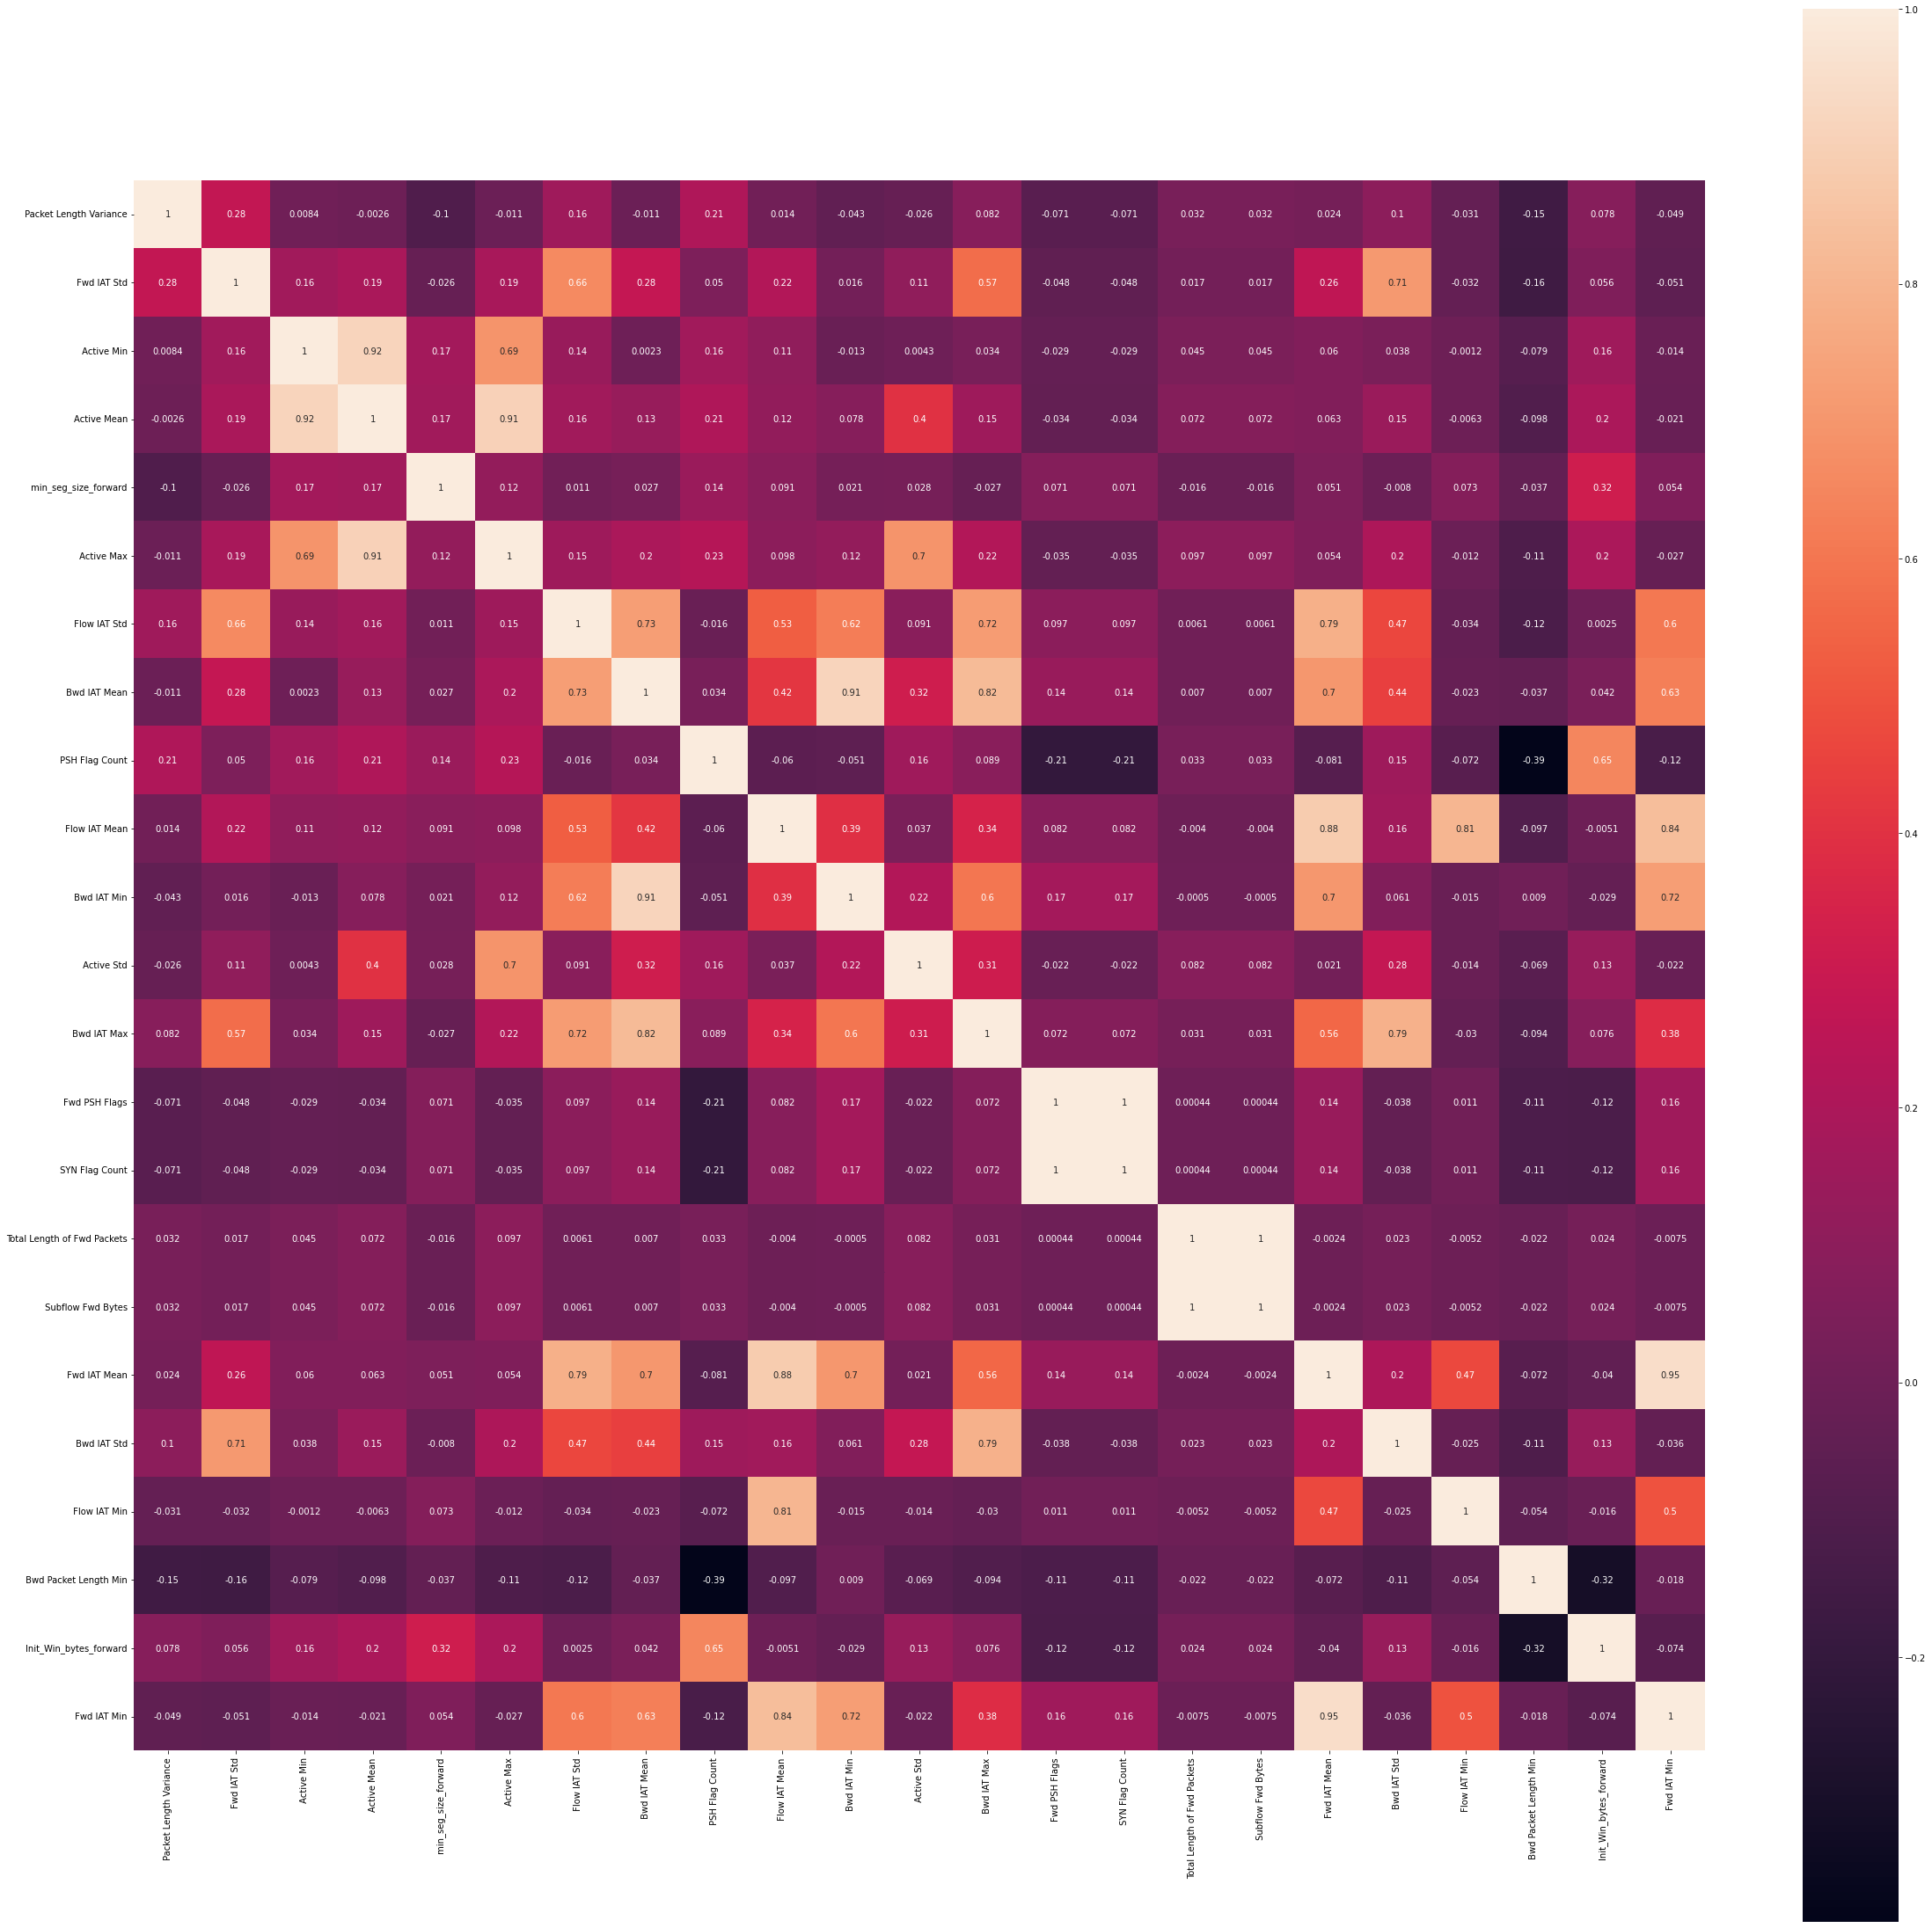

In [115]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

# 16. Дополнительная проверка количества пакетов каждого типа

In [116]:
feature[' Label'].value_counts()

BENIGN                        142069
DoS GoldenEye                  10293
DDoS                           10242
PortScan                        9536
DoS Hulk                        9243
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name:  Label, dtype: int64

In [117]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210706 entries, 24072 to 9242
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0    Packet Length Variance      210706 non-null  float64
 1    Fwd IAT Std                 210706 non-null  float64
 2    Active Min                  210706 non-null  int32  
 3   Active Mean                  210706 non-null  float64
 4    min_seg_size_forward        210706 non-null  int16  
 5    Active Max                  210706 non-null  int32  
 6    Flow IAT Std                210706 non-null  float64
 7    Bwd IAT Mean                210706 non-null  float64
 8    PSH Flag Count              210706 non-null  int8   
 9    Flow IAT Mean               210706 non-null  float64
 10   Bwd IAT Min                 210706 non-null  int32  
 11   Active Std                  210706 non-null  float64
 12   Bwd IAT Max                 210706 non-null  int32  
 1

#**Замена маркировки уникального типа атаки на маркировку Attack (Не используется)**

In [ ]:
#feature[' Label'] = feature[' Label'].replace(to_replace =["FTP-Patator", "Heartbleed", "SSH-Patator", "Infiltration", "DoS GoldenEye", "Web Attack � Sql Injection", "Bot", "PortScan", "DoS Slowhttptest", "DoS slowloris", "DDoS", "DoS Hulk", "Web Attack � XSS", "Web Attack � Brute Force"], value ="ATTACK")

In [ ]:
#feature[' Label'].value_counts()

In [ ]:
#feature.head()

In [ ]:
#feature.info()

In [ ]:
#feature0 = feature[feature[' Label'] == 0]
#feature0.info()

Отбрасываем маркировки пакетов

In [ ]:
#y = feature[' Label']
#X = feature.drop([' Label'],axis=1)

# 17. Разделение датасетов для бинарной классификации

In [118]:
feature0 = feature[feature[' Label'] == 0]
feature0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0    Packet Length Variance      0 non-null      float64
 1    Fwd IAT Std                 0 non-null      float64
 2    Active Min                  0 non-null      int32  
 3   Active Mean                  0 non-null      float64
 4    min_seg_size_forward        0 non-null      int16  
 5    Active Max                  0 non-null      int32  
 6    Flow IAT Std                0 non-null      float64
 7    Bwd IAT Mean                0 non-null      float64
 8    PSH Flag Count              0 non-null      int8   
 9    Flow IAT Mean               0 non-null      float64
 10   Bwd IAT Min                 0 non-null      int32  
 11   Active Std                  0 non-null      float64
 12   Bwd IAT Max                 0 non-null      int32  
 13  Fwd PSH Flags                0 n

In [119]:
feature_buyback = feature #backup feauture w/ benign

In [120]:
feature = feature.set_index(' Label')
feature = feature.drop('BENIGN', axis = 0)
feature = feature.reset_index()
#feature.value_counts() #/проверка


#feature = feature.drop([feature[' Label'] == 'BENIGN'], axis = 0)
#feature = feature.drop(feature.index[feature[' Label'] == 'BENIGN'])

In [121]:
feature_benign_only = feature_buyback.set_index(' Label')
feature_benign_only = feature_benign_only.drop(['FTP-Patator', 'Heartbleed', 'SSH-Patator', 'Infiltration', 'DoS GoldenEye', 'Web Attack � Sql Injection', 'Bot', 'PortScan', 'DoS Slowhttptest', 'DoS slowloris', 'DDoS', 'DoS Hulk', 'Web Attack � XSS', 'Web Attack � Brute Force'], axis=0)
feature_benign_only = feature_benign_only.reset_index()

#feature_benign_only = feature_buyback.drop(feature_buyback.index[feature_buyback[' Label'] != 'BENIGN'])
#feature_benign_only.info()
#'FTP-Patator', 'Heartbleed', 'SSH-Patator', 'Infiltration', 'DoS GoldenEye', 'Web Attack � Sql Injection', 'Bot', 'PortScan', 'DoS Slowhttptest', 'DoS slowloris', 'DDoS', 'DoS Hulk', 'Web Attack � XSS', 'Web Attack � Brute Force'

In [122]:
y = feature[' Label']
X = feature.drop([' Label'],axis=1)

In [123]:
from imblearn.under_sampling import RandomUnderSampler

RandSamp = RandomUnderSampler('majority')
X_RandS, y_RandS = RandSamp.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [124]:
X_RandS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58355 entries, 0 to 58354
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0    Packet Length Variance      58355 non-null  float64
 1    Fwd IAT Std                 58355 non-null  float64
 2    Active Min                  58355 non-null  int32  
 3   Active Mean                  58355 non-null  float64
 4    min_seg_size_forward        58355 non-null  int16  
 5    Active Max                  58355 non-null  int32  
 6    Flow IAT Std                58355 non-null  float64
 7    Bwd IAT Mean                58355 non-null  float64
 8    PSH Flag Count              58355 non-null  int8   
 9    Flow IAT Mean               58355 non-null  float64
 10   Bwd IAT Min                 58355 non-null  int32  
 11   Active Std                  58355 non-null  float64
 12   Bwd IAT Max                 58355 non-null  int32  
 13  Fwd PSH Flags   

In [125]:
y_RandS.value_counts()

DDoS                          10242
PortScan                       9536
DoS Hulk                       9243
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
DoS GoldenEye                    11
Heartbleed                       11
Name:  Label, dtype: int64

# 18 SMOTEtomek

In [126]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek('not majority' ,n_jobs=-1)
X_smt, y_smt = smt.fit_resample(X_RandS, y_RandS)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [127]:
y_smt.value_counts()

Bot                           10242
DoS GoldenEye                 10242
Heartbleed                    10242
Infiltration                  10242
FTP-Patator                   10241
SSH-Patator                   10241
PortScan                      10240
Web Attack � Sql Injection    10238
DDoS                          10226
DoS Slowhttptest              10225
DoS Hulk                      10224
DoS slowloris                 10221
Web Attack � Brute Force       9403
Web Attack � XSS               9403
Name:  Label, dtype: int64

In [128]:
y_smt.head(5)

0    Bot
1    Bot
2    Bot
3    Bot
4    Bot
Name:  Label, dtype: object

In [129]:
X_smt.head(5)

,Packet Length Variance,Fwd IAT Std,Active Min,Active Mean,min_seg_size_forward,Active Max,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Total Length of Fwd Packets,Subflow Fwd Bytes,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Bwd Packet Length Min,Init_Win_bytes_forward,Fwd IAT Min
0,8424.256836,5.268490e+06,50911,63678.199219,32,103175,4.901982e+06,7518953.5,1,3.541332e+06,637,22252.535156,10300000,0,0,322,322,6.396442e+06,4.645138e+06,47,0,29200,234
1,0.000000,0.000000e+00,0,0.000000,32,0,0.000000e+00,0.0,0,5.789100e+04,0,0.000000,0,0,0,0,0,0.000000e+00,0.000000e+00,57891,0,237,0
2,5668.285645,7.612682e+04,0,0.000000,20,0,5.323091e+04,66391.5,1,2.246867e+04,1660,0.000000,131123,0,0,206,206,4.493733e+04,9.154416e+04,123,0,8192,949
3,0.000000,0.000000e+00,0,0.000000,20,0,0.000000e+00,0.0,0,8.400000e+01,0,0.000000,0,0,0,6,6,0.000000e+00,0.000000e+00,84,6,237,0
4,5668.285645,7.217334e+04,0,0.000000,20,0,5.045570e+04,62993.5,1,2.129683e+04,1701,0.000000,124286,0,0,206,206,4.259367e+04,8.668069e+04,75,0,8192,745


In [130]:
X_smt = X_smt.assign(label = y_smt)

In [131]:
X_smt.head(5)

,Packet Length Variance,Fwd IAT Std,Active Min,Active Mean,min_seg_size_forward,Active Max,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Total Length of Fwd Packets,Subflow Fwd Bytes,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Bwd Packet Length Min,Init_Win_bytes_forward,Fwd IAT Min,label
0,8424.256836,5.268490e+06,50911,63678.199219,32,103175,4.901982e+06,7518953.5,1,3.541332e+06,637,22252.535156,10300000,0,0,322,322,6.396442e+06,4.645138e+06,47,0,29200,234,Bot
1,0.000000,0.000000e+00,0,0.000000,32,0,0.000000e+00,0.0,0,5.789100e+04,0,0.000000,0,0,0,0,0,0.000000e+00,0.000000e+00,57891,0,237,0,Bot
2,5668.285645,7.612682e+04,0,0.000000,20,0,5.323091e+04,66391.5,1,2.246867e+04,1660,0.000000,131123,0,0,206,206,4.493733e+04,9.154416e+04,123,0,8192,949,Bot
3,0.000000,0.000000e+00,0,0.000000,20,0,0.000000e+00,0.0,0,8.400000e+01,0,0.000000,0,0,0,6,6,0.000000e+00,0.000000e+00,84,6,237,0,Bot
4,5668.285645,7.217334e+04,0,0.000000,20,0,5.045570e+04,62993.5,1,2.129683e+04,1701,0.000000,124286,0,0,206,206,4.259367e+04,8.668069e+04,75,0,8192,745,Bot


# 19. Конкатенация датасетов

In [132]:
feature_benign_only.head(1)

,Label,Packet Length Variance,Fwd IAT Std,Active Min,Active Mean,min_seg_size_forward,Active Max,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Total Length of Fwd Packets,Subflow Fwd Bytes,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Bwd Packet Length Min,Init_Win_bytes_forward,Fwd IAT Min
0,BENIGN,76.800003,0.0,0,0.0,32,0,55.895737,3.0,0,54.666668,3,0.0,3,0,0,94,94,47.0,0.0,3,63,-1,47


In [133]:
new_cols = [col for col in feature_benign_only.columns if col != ' Label'] + [' Label']
feature_benign_only = feature_benign_only[new_cols]
feature_benign_only.head(1)

,Packet Length Variance,Fwd IAT Std,Active Min,Active Mean,min_seg_size_forward,Active Max,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Total Length of Fwd Packets,Subflow Fwd Bytes,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Bwd Packet Length Min,Init_Win_bytes_forward,Fwd IAT Min,Label
0,76.800003,0.0,0,0.0,32,0,55.895737,3.0,0,54.666668,3,0.0,3,0,0,94,94,47.0,0.0,3,63,-1,47,BENIGN


In [134]:
feature_benign_only.rename(columns = {' Label':'label'}, inplace = True)

In [135]:
dfs = [X_smt, feature_benign_only]
result = pd.concat(dfs)

In [136]:
result.head(1)

,Packet Length Variance,Fwd IAT Std,Active Min,Active Mean,min_seg_size_forward,Active Max,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Total Length of Fwd Packets,Subflow Fwd Bytes,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Bwd Packet Length Min,Init_Win_bytes_forward,Fwd IAT Min,label
0,8424.256836,5268490.0,50911,63678.199219,32,103175,4901981.5,7518953.5,1,3541331.75,637,22252.535156,10300000,0,0,322,322,6396442.0,4645137.5,47,0,29200,234,Bot


# 20. Сохраним и разделим датасет на тестовую и тренировочную часть 

In [137]:
X_smt.to_csv('/content/drive/MyDrive/CICIDS2017/final masterвфыафыа', index = False)

In [138]:
#X_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt.csv')
#y_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/y_smt.csv')

# 21. Сохраним и разделим датасет на тестовую и тренировочную часть БЕЗ SMOTET

In [ ]:
#X = X.assign(label = y)
#X.to_csv('/content/drive/MyDrive/CICIDS2017/final master/X.csv', index = False)

# 22. Разделение датасета на тестовый и тренировочный

In [139]:
#X_smt=pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt.csv')
#y_smt=pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/y_smt.csv')


#train_X,test_X,train_y,test_y=train_test_split(X_smt,y_smt,test_size=0.3, random_state=10)

#from numpy.random import RandomState
#rng = RandomState()

#train_X = X_smt.sample(frac=0.7, random_state=rng)
#test_X = X_smt.loc[~X_smt.index.isin(train_X.index)]

#train_y = y_smt.sample(frac=0.7, random_state=rng)
#test_y = y_smt.loc[~X_smt.index.isin(train_y.index)]

In [140]:
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/final master/X_smt_binbalance.csv')
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82060 entries, 0 to 82059
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    min_seg_size_forward     82060 non-null  int64  
 1    Active Min               82060 non-null  int64  
 2   Active Mean               82060 non-null  float64
 3    Init_Win_bytes_backward  82060 non-null  int64  
 4    Fwd IAT Std              82060 non-null  float64
 5    Active Max               82060 non-null  int64  
 6    Packet Length Variance   82060 non-null  float64
 7    Bwd IAT Mean             82060 non-null  float64
 8    Total Backward Packets   82060 non-null  int64  
 9    Subflow Bwd Packets      82060 non-null  int64  
 10   PSH Flag Count           82060 non-null  int64  
 11  Fwd PSH Flags             82060 non-null  int64  
 12   SYN Flag Count           82060 non-null  int64  
 13   Bwd IAT Min              82060 non-null  int64  
 14   Flow 

In [141]:
#!head -n 4000 '/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv'

# 24. Отделение "BENIGN" от всего датасета

In [142]:
data = []
target = []
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/final master/X_smt_binbalance.csv')
for n, i in file.iterrows():
  a = []
  for j in i[:-1]:
    a.append(j)
  data.append(a)

  target.append(0 if i[-1] == 'BENIGN' else 1) #0 benign 1 attack
del file

In [143]:
data[:2]

[[32, 0, 0.0, 110, 0.0, 0, 0.0, 0.0, 1, 1, 0, 0, 0, 0, 0.0, 237, 0, 1, 1],
 [20,
  0,
  0.0,
  237,
  76126.8203125,
  0,
  5668.28564453125,
  66391.5,
  3,
  3,
  1,
  0,
  0,
  1660,
  53230.91015625,
  8192,
  0,
  0,
  0]]

In [144]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.nan_to_num(data).astype(float))
data = scaler.transform(np.nan_to_num(data).astype(float))
data = data.reshape(data.shape[0], 19)

In [145]:
#pickle.dump(scaler, open('/content/drive/MyDrive/CICIDS2017/final master/scaler_nosmt.pkl', 'wb'))

# 25. Соединение датасета и отделение бенигн (класс 0) и всех остальных как атаки

In [146]:
data = np.array(data)
target = np.array(target)
print(data.shape, target.shape)

(82060, 19) (82060,)


# 26. Моделирование бинарной нейросети LSTM.

In [147]:
lstm = Sequential()
lstm.add(Input((19, 1)))
lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
for i in range(4):
  lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
lstm.add(Flatten())
lstm.add(Dense(2 ,activation = 'softmax'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 19, 32)            4352      
                                                                 
 lstm_6 (LSTM)               (None, 19, 32)            8320      
                                                                 
 lstm_7 (LSTM)               (None, 19, 32)            8320      
                                                                 
 lstm_8 (LSTM)               (None, 19, 32)            8320      
                                                                 
 lstm_9 (LSTM)               (None, 19, 32)            8320      
                                                                 
 flatten_1 (Flatten)         (None, 608)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                

Тренировка нейросети

In [148]:
lstm.fit(data, to_categorical(target), epochs=28, batch_size=256, verbose=1)

Epoch 1/28
321/321 [==============================] - 25s 60ms/step - loss: 0.4352 - accuracy: 0.8333
Epoch 2/28
321/321 [==============================] - 19s 60ms/step - loss: 0.3859 - accuracy: 0.8351
Epoch 3/28
321/321 [==============================] - 19s 60ms/step - loss: 0.3838 - accuracy: 0.8351
Epoch 4/28
321/321 [==============================] - 19s 60ms/step - loss: 0.3811 - accuracy: 0.8351
Epoch 5/28
321/321 [==============================] - 19s 59ms/step - loss: 0.3740 - accuracy: 0.8372
Epoch 6/28
321/321 [==============================] - 19s 60ms/step - loss: 0.3642 - accuracy: 0.8398
Epoch 7/28
321/321 [==============================] - 19s 60ms/step - loss: 0.3632 - accuracy: 0.8404
Epoch 8/28
321/321 [==============================] - 19s 60ms/step - loss: 0.4422 - accuracy: 0.8353
Epoch 9/28
321/321 [==============================] - 19s 59ms/step - loss: 0.3883 - accuracy: 0.8370
Epoch 10/28
321/321 [==============================] - 19s 59ms/step - loss: 0.363

In [152]:
lstm.save('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/lstm_fitted.h5')
#lstm = load_model('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/lstm_fitted.h5')

Получение данных от нейросети

In [149]:
y_pred1 = lstm.predict(data, batch_size=256)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик 

In [150]:
from sklearn import metrics
from sklearn.metrics import classification_report
target_names = ['Benign', 'Attack']
print('==============================Classification Report=============================='.format(i))
print(classification_report(target, y_pred, target_names=target_names))
print('==============================Confussion Matrix and metrics=============================='.format(i))
tn, fp, fn, tp = confusion_matrix(target, y_pred).ravel()
sum = tn + fp + fn + tp
print('Confussion Matrix:', "\n", confusion_matrix(target, y_pred))
print("Accuracy: ", accuracy_score(target, y_pred))
recall = tp / (tp + fn)
print('recall:', recall)
precision = tp / (tp + fp)
print('precision:', precision)
print('f1 score:', 2 * (precision * recall) / (precision + recall))
print('ROC AUC:', roc_auc_score(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Alghorythm marked', count_list[1], 'as attack and', count_list[0], "packets as benign")

==============================Classification Report==============================
              precision    recall  f1-score   support

      Benign       0.82      0.43      0.57     13531
      Attack       0.90      0.98      0.94     68529

    accuracy                           0.89     82060
   macro avg       0.86      0.71      0.75     82060
weighted avg       0.89      0.89      0.88     82060

==============================Confussion Matrix and metrics==============================
Confussion Matrix: 
 [[ 5858  7673]
 [ 1266 67263]]
Accuracy:  0.8910675115768949
recall: 0.9815260692553518
precision: 0.8976059570833779
f1 score: 0.9376921200292755
ROC AUC: 0.7072289277619601
Alghorythm marked 74936 as attack and 7124 packets as benign


# 27. Моделирование мультиклассовой нейросети KNN.


Чтение датасета для второй нейросети. 

In [ ]:
data = []
target = []
last = []

file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv')
for n, i in file.iterrows():
    if not i[-1] in last:
        last.append(i[-1])
    if last.index(i[-1]) != 0:
      a = []
      for j in i[:-1]:
          a.append(j)
      data.append(a)
      target.append(last.index(i[-1])-1)
del file
del last[0]

Обработка

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 19)
print(data.shape, target.shape)

(141344, 19) (141344,)


**Загрузка** нормализатора

In [ ]:
scaler = pickle.load(open('/content/drive/MyDrive/CICIDS2017/devtest/scaler.pkl', 'rb'))

Нормализация данных для второй нейросети

In [ ]:
data = scaler.transform(np.nan_to_num(data).astype(float))

Моделирование мультиклассовой нейросети

In [ ]:
knn = Sequential()
knn.add(InputLayer((19,)))
knn.add(BatchNormalization())
knn.add(Dense(128, activation='relu'))
knn.add(Dense(128, activation='relu'))
knn.add(Dense(14, activation='softmax'))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
knn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

Тренировка второй нейросети

In [ ]:
knn.fit(data.astype(float), target, epochs=192, batch_size=256, verbose=1)

knn.save('/content/drive/MyDrive/CICIDS2017/devtest/knn.h5')

Epoch 1/192
553/553 [==============================] - 2s 3ms/step - loss: 0.7744 - accuracy: 0.7048
Epoch 2/192
553/553 [==============================] - 2s 3ms/step - loss: 0.5351 - accuracy: 0.7744
Epoch 3/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4972 - accuracy: 0.7870
Epoch 4/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4700 - accuracy: 0.7990
Epoch 5/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4583 - accuracy: 0.7998
Epoch 6/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4503 - accuracy: 0.8016
Epoch 7/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4417 - accuracy: 0.8038
Epoch 8/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4400 - accuracy: 0.8061
Epoch 9/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4296 - accuracy: 0.8096
Epoch 10/192
553/553 [==============================] - 2s 3ms/step - loss: 0.4228 - accura

Получение данных со второй нейросети

In [ ]:
y_pred1 = knn.predict(data)
y_pred = np.argmax(y_pred1, axis=1)


Вычисление метрик и количество классов

In [ ]:
target_names = ['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']
print('==============================Classification Report=============================='.format(i))
print(classification_report(target, y_pred, target_names=target_names))
print('==============================Confussion Matrix and metrics=============================='.format(i))
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(to_categorical(target), np.nan_to_num(y_pred1), multi_class='ovr'))
print('Confussion Matrix:', "\n", confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Классы:')
for i in count_list:
  print(last[i], count_list[i])

==============================Classification Report==============================
                            precision    recall  f1-score   support

                       Bot       0.93      1.00      0.96     10284
                      DDoS       0.99      0.97      0.98     10242
             DoS GoldenEye       1.00      0.73      0.84     10286
                  DoS Hulk       0.77      0.94      0.85     10250
          DoS Slowhttptest       0.98      0.90      0.94     10268
             DoS slowloris       0.97      0.87      0.92     10275
               FTP-Patator       0.85      1.00      0.92     10293
                Heartbleed       1.00      1.00      1.00     10293
              Infiltration       1.00      0.99      0.99     10292
                  PortScan       1.00      1.00      1.00     10289
               SSH-Patator       0.66      0.99      0.79     10292
  Web Attack � Brute Force       0.99      0.17      0.29      8999
Web Attack � Sql Injection       

In [ ]:
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(to_categorical(target), np.nan_to_num(y_pred1), multi_class='ovr'))
print('матрица неточностей', confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Классы:')
for i in count_list:
  print(last[i], count_list[i])

recall: 0.8790114896988906
precision: 0.8790114896988906
accuracy: 0.8790114896988906
f1 score: 0.8790114896988906
ROC AUC: 0.9949336483570361
матрица неточностей [[10271     8     0     0     0     0     0     0     0     0     5     0
      0     0]
 [   12 10077     0   153     0     0     0     0     0     0     0     0
      0     0]
 [    0     0  7497  2577     1     3     0     0     0     0     0     0
    206     2]
 [  320   181     0  9707     0     3     0     0     0     0    38     0
      0     1]
 [    0     1     3    47  9225   199   774     0     0     9     7     0
      0     3]
 [    2     0     2    16   114  9044   939     0     0     6   148     0
      0     4]
 [    0     0     0    14     0     0 10269     0     0     0     9     0
      0     1]
 [    0     0     0     0     0     0     0 10293     0     0     0     0
      0     0]
 [  144     0     0     0     0     0     0     0 10148     0     0     0
      0     0]
 [    0     0     0     2    30     

-

-

-

# 28. Проверка нейросети

Загрузка заранее обученной нейросети

In [76]:
lstm = load_model('/content/drive/MyDrive/CICIDS2017/devtest/lstm.h5')
knn = load_model('/content/drive/MyDrive/CICIDS2017/devtest/knn.h5')

SystemError: ignored

Загрузка данных для тестирования нейросети

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/data_analysis/Wednesday-workingHours.pcap_ISCX.csv')
data = []
target = []

for n, i in file.iterrows():
        a = []
        for j in i[:-1]:
          a.append(j)
        data.append(a)
        target.append(last.index(i[-1]))

Обработка данных

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78, 1)
print(data.shape, target.shape)

Проверка нейросети

In [ ]:
model.evaluate(data, target)

Предсказание нейросети

In [ ]:
pred = model.predict(data)

Определение класса предсказанния нейросети

In [ ]:
print(last[np.argmax(pred[5])])